## 1. 变分自编码器 variational autoencoder (VAE)

[VAE论文](https://arxiv.org/pdf/1312.6114)

这里有篇很好的文章：[From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)

In [5]:
from IPython.display import Image, display
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png'
display(Image(url=url, width=600))

In [6]:
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/VAE-graphical-model.png'
display(Image(url=url, width=600))

In [7]:
url = 'https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png'
display(Image(url=url, width=600))

第一张图：autoencoder可以看作是矩阵分解，类比SVD  
第二张图：概率图模型框架下VAE，观测由隐变量z生成  
第三张图：VAE的一些细节。可以用很多词对去描述这个过程，比如编码-解码；降维-升维；压缩-还原；推入-拉回。从观测到潜在分布，称之为学习；从潜在分布生成数据，称之为推断。  

---

## 2. 数学表达式

模型假定数据$x$由某个潜变量$z$生成

潜变量$z$具有某个先验分布$p(z)$，一般假定为标准正态分布. $z\sim N(0,I)$

模型的联合概率分布为 $p_\theta(x,z)=p_\theta(x|z)p(z)$

目标是最大化$x$的边缘似然 $$p_\theta(x)=\int p_\theta(x|z)p(z)dz$$

因为积分计算困难，引入变分推断。

---

引入变分分布$q_\phi(z|x)$迫近真实后验分布$p_\theta(z|x)$

为衡量迫近程度，需要度量两个分布之间的距离，使其最小化。采用KL散度，根据定义
$$D_{KL}(q_\phi(z|x)||p_\theta(z|x)) = \mathbb{E}_{q_\phi(z|x)}\left[log\frac{q_\phi(z|x)}{p_\theta(z|x)}\right] $$

注：实际上，我们定义了一个的参数分布族$\{p_\theta\}_{\theta\in\Theta}$

然后寻找最优分布以最小化某个损失函数$L(\theta)$，这是一类泛函极值问题，来源于最速降线问题。

变分推断另一个常见的场景是混合高斯模型（Gaussian Mixture Model，GMM）

---

**琴生不等式**  
如果f(x)是凸函数  
在二元情况下有：$\frac{f(x_1)+f(x_2)}{2}\geqslant f(\frac{x_1+x_2}{2})$  

在n元情况下有：$\frac{f(x_1)+f(x_2)+\cdots+f(x_n)}{n}\geqslant f(\frac{x_1+x_2+\cdots+x_n}{n})$ 

由于琴生不等式在加权的情况下也成立，即
$\frac{\alpha_1f(x_1)+\alpha_2f(x_2)+\cdots+\alpha_nf(x_n)}{\alpha_1+\alpha_1+\cdots+\alpha_n}\geqslant f(\frac{\alpha_1x_1+\alpha_2x_2+\cdots+\alpha_nx_n}{\alpha_1+\alpha_1+\cdots+\alpha_n})$  

不等式左边是函数值的期望，右边是期望的函数值，即 $\mathbb{E}[f(x)]\geqslant f(\mathbb{E}(x))$  

在f(x)是凹函数的情况下，有对应的不等式。log(x)是凹函数，于是 $\mathbb{E}[log(x)]\leqslant log(\mathbb{E}(x))$

---

目标的对数边缘似然：
$$\log p_\theta(x)=\log \int p_\theta(x,z)dz=\log \int \frac{p_\theta(x,z)}{q_\phi(z|x)} q_\phi(z|x)dz$$


$$\geqslant \int \log \frac{p_\theta(x,z)}{q_\phi(z|x)} q_\phi(z|x)dz
=\mathbb{E}_{q_\phi(z|x)}\log \frac{p_\theta(x,z)}{q_\phi(z|x)}
=\mathbb{E}_{q_\phi(z|x)}\log \frac{p_\theta(x|z) p(z)}{q_\phi(z|x)}$$

$$=\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)-D_{KL}(q_\phi(z|x)||p(z))$$

不等式右边的结果称为证据下界（evidence lower bound, ELBO），又称变分下界或负变分自由能。  
ELBO由两项构成，第一项称为重构项，衡量解码器从潜在变量z重构数据x的能力，类似于自编码器的重建损失（如交叉熵或均方误差）；第二项是正则项，约束近似后验接近先验，防止过拟合。  
下界的意思是至少是这么多，因此为了最大化目标函数，就需要最大化ELBO，等价与最小化ELBO的负值（优化理论约定），于是有
$$\arg \mathop{\min}_{\theta,\phi}D_{KL}(q_\phi(z|x)||p(z))-\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)$$


---

编码器建模：$q_\phi(z|x)$  

通常假定为对角高斯分布。$q_\phi(z|x)=\mathcal{N}(z;\mu_\phi(x),\sigma_\phi^2(x))$ 

解码器建模：$p_\theta(x|z)$  

根据数据类型选择分布：二值数据（如黑白的MNIST）用伯努利分布；连续数据（如CIFAR-10, 256个值）用高斯分布。

为了收敛性，使用重参数化技巧（[Reparameterization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/)），采样$z\sim q_\phi(z|x)$，于是  

$z=\mu_\phi(x)+\sigma_\phi(x)\odot\epsilon, \epsilon \sim \mathcal{N}(0, I) $


In [9]:
url = 'https://gregorygundersen.com/image/reparam/vae.png'
display(Image(url=url, width=600))

因为$q_\phi(z|x)$是对角高斯分布，$p(z)$是标准正态分布，则$D_{KL}(q_\phi(z|x)||p(z))$项有闭式解。  
$$D_{KL}(\mathcal{N}(\mu_\phi(x),\sigma^2_\phi(x)I)||\mathcal{N}(0,I))
=\frac{1}{2}\sum_{i=1}^d(\mu_i^2+\sigma^2_i-1-ln\sigma^2_i)$$

第二项，通过蒙特卡洛方法计算，但一般只取一个样本！

---

后续优化：
（1）$\beta$-VAE：引入超参数$\beta$，强化正则项。$\mathcal{L}(\theta, \phi)=-\mathbb{E}_{q_\phi(z|x)}\log p_\theta(x|z)+\beta\cdot D_{KL}(q_\phi(z|x)||p(z))$     

论文[$\beta$-VAE](https://www.cs.toronto.edu/~bonner/courses/2022s/csc2547/papers/generative/disentangled-representations/beta-vae,-higgins,-iclr2017.pdf)

（2）CVAE：引入条件变量$y$，建模$p_\theta(x|z,y)$  

论文[CVAE](https://arxiv.org/pdf/1812.04405)

（3）VQVAE：使用向量量化（Vector Quantization）改进潜在表示。

论文[VQVAE](https://arxiv.org/pdf/1711.00937)

## 3. 简单实现

In [2]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [3]:
# 超参数
image_size = 256
downscale = 4
batch_size = 2
in_channels = 3
out_channels = 3
epochs = 100
learning_rate = 1e-4
save_path = 'model_pkl/vae_updated.pth'
data_path = 'data/celeba_hq_256/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
# CelebA-HQ Super-Resolution Dataset
class CelebASuperRes(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, size=256, downscale=4):
        self.root = root
        self.transform = transform
        self.size = size
        self.downscale = downscale
        self.images = [f for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx])).convert('RGB')
        hr = transforms.Resize((self.size, self.size))(img)
        lr = transforms.Resize((self.size // self.downscale, self.size // self.downscale))(hr)
        lr = transforms.Resize((self.size, self.size), interpolation=Image.BICUBIC)(lr)
        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        return hr, lr

In [6]:
dataset = CelebASuperRes(data_path, transform=transform, size=image_size, downscale=downscale)
subset_dataset = Subset(dataset, range(500))
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
unloader = transforms.ToPILImage()

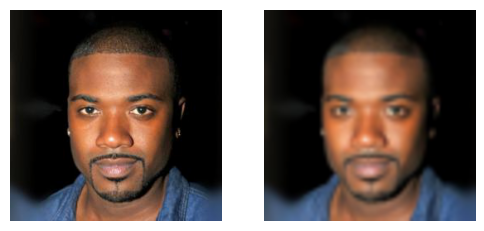

In [7]:
for x, y in dataloader:
    img1, img2 = x[0], y[0]
    img1 = denormalize(img1, mean, std)[0]
    img2 = denormalize(img2, mean, std)[0]
    img1 = unloader(img1)
    img2 = unloader(img2)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[1].imshow(img2)
    axes[1].axis('off')
    plt.show()
    break

In [8]:
class ResBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.GELU(),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            # nn.GroupNorm(8, in_channels),
            # nn.GELU(),
            # nn.Conv2d(in_channels, in_channels, 3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_norm = self.norm(x)
        q, k, v = self.qkv(x_norm).chunk(3, dim=1)
        q, k, v = [t.reshape(B, C, H * W).transpose(1, 2) for t in (q, k, v)]  # B, HW, C

        attn = torch.bmm(q, k.transpose(1, 2)) * (C ** -0.5)
        attn = attn.softmax(dim=-1)
        out = torch.bmm(attn, v).transpose(1, 2).reshape(B, C, H, W)
        return x + self.proj(out)

In [10]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ResBlock(in_channels),
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
        )

    def forward(self, x):
        return self.block(x)

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ResBlock(in_channels),
            nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
        )

    def forward(self, x):
        return self.block(x)

In [11]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=256):
        super().__init__()

        # ----------------- Encoder -----------------
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            ResBlock(64),
        )  # -> 256x256
        self.enc2 = Downsample(64, 128)      # -> 128x128
        self.enc3 = Downsample(128, 256)     # -> 64x64
        self.attn1 = AttentionBlock(256)

        self.enc4 = Downsample(256, 512)     # -> 32x32
        self.attn2 = AttentionBlock(512)

        # self.enc5 = Downsample(512, 512)     # -> 16x16
        # self.attn3 = AttentionBlock(512)

        self.to_latent = nn.Conv2d(512, latent_dim, 3, padding=1)
        self.conv_mu = nn.Conv2d(latent_dim, latent_dim, 1)
        self.conv_logvar = nn.Conv2d(latent_dim, latent_dim, 1)

        # ----------------- Decoder -----------------
        self.dec_in = ResBlock(latent_dim)

        self.up1 = Upsample(latent_dim, 256)    # 32x32 → 64x64
        self.attn_dec1 = AttentionBlock(256)

        self.up2 = Upsample(256 + 256, 128)     # 64x64 → 128x128
        self.attn_dec2 = AttentionBlock(128)

        self.up3 = Upsample(128 + 128, 64)     # 128x128 → 256x256
        # self.up4 = Upsample(64 + 64, 32)      

        self.final = nn.Sequential(
            nn.Conv2d(64 + 64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, in_channels, 3, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        s3 = self.attn1(self.enc3(s2))
        s4 = self.attn2(self.enc4(s3))
        # s5 = self.attn3(self.enc5(s4))
        z = self.to_latent(s4)
        mu = self.conv_mu(z)
        logvar = self.conv_logvar(z)
        return mu, logvar, [s1, s2, s3, s4]

    def decode(self, z, skips):
        x = self.dec_in(z)
        x = self.up1(x)
        x = self.attn_dec1(x)
        x = self.up2(torch.cat([x, skips[2]], dim=1))
        x = self.attn_dec2(x)
        x = self.up3(torch.cat([x, skips[1]], dim=1))
        # x = self.up4(torch.cat([x, skips[0]], dim=1))
        x = self.final(torch.cat([x, skips[0]], dim=1))
        return x

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, skips)
        return recon, mu, logvar

In [12]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div, recon_loss, kl_div

In [13]:
## 初始化模型
model = VAE()
# summary(model, input_size=(4, 3, 256, 256))

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
model.to(device)
scaler = GradScaler()
best_loss = float('inf')  # 初始化为正无穷
accumulation_steps = 16  # 定义累积步数
for epoch in range(epochs):
    model.train()
    total_loss, total_recon, total_kl = 0.0, 0.0, 0.0

    # beta = min(1.0, epoch / 10.0)  # KL warmup
    pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    optimizer.zero_grad()
    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)

        with autocast(device_type='cuda'):
            recon, mu, logvar = model(images)
            loss, recon_loss, kl_div = vae_loss(recon, images, mu, logvar)

        loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        total_recon += recon_loss.item()
        total_kl += kl_div.item()

        pbar.set_postfix(loss=total_loss)

    # 补充最后一组未step的梯度
    if (batch_idx + 1) % accumulation_steps != 0:
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Recon: {total_recon:.4f} | KL: {total_kl:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        print("Best model saved.")

Epoch 1: 100%|██████████████████████████████████████████████████████████| 250/250 [03:19<00:00,  1.25it/s, loss=0.0189]


Epoch 1/100 | Loss: 0.7965 | Recon: 197.9705 | KL: 1.1491
Best model saved.


Epoch 2: 100%|██████████████████████████████████████████████████████████| 250/250 [03:17<00:00,  1.27it/s, loss=0.0154]


Epoch 2/100 | Loss: 0.3135 | Recon: 77.8525 | KL: 0.5222
Best model saved.


Epoch 3: 100%|██████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0196]


Epoch 3/100 | Loss: 0.2889 | Recon: 71.9921 | KL: 0.2287
Best model saved.


Epoch 4: 100%|██████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0207]


Epoch 4/100 | Loss: 0.2799 | Recon: 69.8284 | KL: 0.1436
Best model saved.


Epoch 5: 100%|██████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0172]


Epoch 5/100 | Loss: 0.2749 | Recon: 68.6246 | KL: 0.1073
Best model saved.


Epoch 6: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.00708]


Epoch 6/100 | Loss: 0.2719 | Recon: 67.8857 | KL: 0.0968
Best model saved.


Epoch 7: 100%|██████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0396]


Epoch 7/100 | Loss: 0.2697 | Recon: 67.3271 | KL: 0.0873
Best model saved.


Epoch 8: 100%|██████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0139]


Epoch 8/100 | Loss: 0.2678 | Recon: 66.8763 | KL: 0.0809
Best model saved.


Epoch 9: 100%|██████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0233]


Epoch 9/100 | Loss: 0.2671 | Recon: 66.6937 | KL: 0.0793
Best model saved.


Epoch 10: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0138]


Epoch 10/100 | Loss: 0.2678 | Recon: 66.8652 | KL: 0.0809


Epoch 11: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0176]


Epoch 11/100 | Loss: 0.2658 | Recon: 66.3789 | KL: 0.0712
Best model saved.


Epoch 12: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0126]


Epoch 12/100 | Loss: 0.2649 | Recon: 66.1737 | KL: 0.0622
Best model saved.


Epoch 13: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0185]


Epoch 13/100 | Loss: 0.2642 | Recon: 66.0024 | KL: 0.0574
Best model saved.


Epoch 14: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0127]


Epoch 14/100 | Loss: 0.2638 | Recon: 65.8981 | KL: 0.0533
Best model saved.


Epoch 15: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0306]


Epoch 15/100 | Loss: 0.2632 | Recon: 65.7496 | KL: 0.0494
Best model saved.


Epoch 16: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0134]


Epoch 16/100 | Loss: 0.2629 | Recon: 65.6690 | KL: 0.0475
Best model saved.


Epoch 17: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00584]


Epoch 17/100 | Loss: 0.2625 | Recon: 65.5867 | KL: 0.0455
Best model saved.


Epoch 18: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0126]


Epoch 18/100 | Loss: 0.2623 | Recon: 65.5210 | KL: 0.0437
Best model saved.


Epoch 19: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0156]


Epoch 19/100 | Loss: 0.2620 | Recon: 65.4585 | KL: 0.0423
Best model saved.


Epoch 20: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00634]


Epoch 20/100 | Loss: 0.2620 | Recon: 65.4628 | KL: 0.0414


Epoch 21: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0156]


Epoch 21/100 | Loss: 0.2618 | Recon: 65.4037 | KL: 0.0397
Best model saved.


Epoch 22: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00802]


Epoch 22/100 | Loss: 0.2616 | Recon: 65.3536 | KL: 0.0378
Best model saved.


Epoch 23: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00914]


Epoch 23/100 | Loss: 0.2615 | Recon: 65.3286 | KL: 0.0362
Best model saved.


Epoch 24: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0103]


Epoch 24/100 | Loss: 0.2612 | Recon: 65.2689 | KL: 0.0355
Best model saved.


Epoch 25: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0159]


Epoch 25/100 | Loss: 0.2612 | Recon: 65.2643 | KL: 0.0343
Best model saved.


Epoch 26: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0051]


Epoch 26/100 | Loss: 0.2608 | Recon: 65.1723 | KL: 0.0332
Best model saved.


Epoch 27: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0232]


Epoch 27/100 | Loss: 0.2606 | Recon: 65.1219 | KL: 0.0323
Best model saved.


Epoch 28: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0127]


Epoch 28/100 | Loss: 0.2605 | Recon: 65.0908 | KL: 0.0319
Best model saved.


Epoch 29: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.28it/s, loss=0.0147]


Epoch 29/100 | Loss: 0.2603 | Recon: 65.0538 | KL: 0.0313
Best model saved.


Epoch 30: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0194]


Epoch 30/100 | Loss: 0.2602 | Recon: 65.0206 | KL: 0.0304
Best model saved.


Epoch 31: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.0107]


Epoch 31/100 | Loss: 0.2602 | Recon: 65.0292 | KL: 0.0300


Epoch 32: 100%|██████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.011]


Epoch 32/100 | Loss: 0.2601 | Recon: 64.9993 | KL: 0.0294
Best model saved.


Epoch 33: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.28it/s, loss=0.0386]


Epoch 33/100 | Loss: 0.2599 | Recon: 64.9557 | KL: 0.0285
Best model saved.


Epoch 34: 100%|█████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.28it/s, loss=0.0125]


Epoch 34/100 | Loss: 0.2598 | Recon: 64.9335 | KL: 0.0283
Best model saved.


Epoch 35: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0221]


Epoch 35/100 | Loss: 0.2598 | Recon: 64.9123 | KL: 0.0277
Best model saved.


Epoch 36: 100%|███████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.01]


Epoch 36/100 | Loss: 0.2597 | Recon: 64.8887 | KL: 0.0274
Best model saved.


Epoch 37: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0199]


Epoch 37/100 | Loss: 0.2597 | Recon: 64.9020 | KL: 0.0268


Epoch 38: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0125]


Epoch 38/100 | Loss: 0.2600 | Recon: 64.9624 | KL: 0.0267


Epoch 39: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0069]


Epoch 39/100 | Loss: 0.2598 | Recon: 64.9256 | KL: 0.0260


Epoch 40: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0136]


Epoch 40/100 | Loss: 0.2596 | Recon: 64.8658 | KL: 0.0251
Best model saved.


Epoch 41: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0146]


Epoch 41/100 | Loss: 0.2594 | Recon: 64.8299 | KL: 0.0248
Best model saved.


Epoch 42: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0131]


Epoch 42/100 | Loss: 0.2594 | Recon: 64.8191 | KL: 0.0245
Best model saved.


Epoch 43: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0125]


Epoch 43/100 | Loss: 0.2593 | Recon: 64.7968 | KL: 0.0241
Best model saved.


Epoch 44: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0112]


Epoch 44/100 | Loss: 0.2592 | Recon: 64.7799 | KL: 0.0238
Best model saved.


Epoch 45: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0119]


Epoch 45/100 | Loss: 0.2592 | Recon: 64.7655 | KL: 0.0236
Best model saved.


Epoch 46: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0201]


Epoch 46/100 | Loss: 0.2591 | Recon: 64.7534 | KL: 0.0233
Best model saved.


Epoch 47: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0127]


Epoch 47/100 | Loss: 0.2591 | Recon: 64.7437 | KL: 0.0230
Best model saved.


Epoch 48: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0121]


Epoch 48/100 | Loss: 0.2590 | Recon: 64.7384 | KL: 0.0227
Best model saved.


Epoch 49: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0209]


Epoch 49/100 | Loss: 0.2590 | Recon: 64.7250 | KL: 0.0224
Best model saved.


Epoch 50: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0283]


Epoch 50/100 | Loss: 0.2590 | Recon: 64.7167 | KL: 0.0222
Best model saved.


Epoch 51: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00912]


Epoch 51/100 | Loss: 0.2589 | Recon: 64.7080 | KL: 0.0219
Best model saved.


Epoch 52: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0112]


Epoch 52/100 | Loss: 0.2589 | Recon: 64.7010 | KL: 0.0217
Best model saved.


Epoch 53: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0078]


Epoch 53/100 | Loss: 0.2589 | Recon: 64.6968 | KL: 0.0215
Best model saved.


Epoch 54: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0235]


Epoch 54/100 | Loss: 0.2588 | Recon: 64.6868 | KL: 0.0211
Best model saved.


Epoch 55: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0136]


Epoch 55/100 | Loss: 0.2588 | Recon: 64.6816 | KL: 0.0210
Best model saved.


Epoch 56: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00992]


Epoch 56/100 | Loss: 0.2588 | Recon: 64.6763 | KL: 0.0208
Best model saved.


Epoch 57: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0335]


Epoch 57/100 | Loss: 0.2588 | Recon: 64.6686 | KL: 0.0206
Best model saved.


Epoch 58: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0108]


Epoch 58/100 | Loss: 0.2587 | Recon: 64.6632 | KL: 0.0203
Best model saved.


Epoch 59: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0273]


Epoch 59/100 | Loss: 0.2587 | Recon: 64.6571 | KL: 0.0202
Best model saved.


Epoch 60: 100%|██████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.011]


Epoch 60/100 | Loss: 0.2587 | Recon: 64.6513 | KL: 0.0200
Best model saved.


Epoch 61: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0307]


Epoch 61/100 | Loss: 0.2587 | Recon: 64.6467 | KL: 0.0199
Best model saved.


Epoch 62: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0265]


Epoch 62/100 | Loss: 0.2586 | Recon: 64.6426 | KL: 0.0196
Best model saved.


Epoch 63: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0245]


Epoch 63/100 | Loss: 0.2586 | Recon: 64.6378 | KL: 0.0195
Best model saved.


Epoch 64: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0389]


Epoch 64/100 | Loss: 0.2586 | Recon: 64.6354 | KL: 0.0194
Best model saved.


Epoch 65: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0244]


Epoch 65/100 | Loss: 0.2586 | Recon: 64.6329 | KL: 0.0192
Best model saved.


Epoch 66: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0228]


Epoch 66/100 | Loss: 0.2586 | Recon: 64.6268 | KL: 0.0191
Best model saved.


Epoch 67: 100%|████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.00766]


Epoch 67/100 | Loss: 0.2586 | Recon: 64.6235 | KL: 0.0190
Best model saved.


Epoch 68: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0135]


Epoch 68/100 | Loss: 0.2585 | Recon: 64.6185 | KL: 0.0189
Best model saved.


Epoch 69: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0125]


Epoch 69/100 | Loss: 0.2585 | Recon: 64.6156 | KL: 0.0188
Best model saved.


Epoch 70: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0118]


Epoch 70/100 | Loss: 0.2585 | Recon: 64.6129 | KL: 0.0187
Best model saved.


Epoch 71: 100%|█████████████████████████████████████████████████████████| 250/250 [03:15<00:00,  1.28it/s, loss=0.0126]


Epoch 71/100 | Loss: 0.2585 | Recon: 64.6098 | KL: 0.0186
Best model saved.


Epoch 72: 100%|█████████████████████████████████████████████████████████| 250/250 [03:18<00:00,  1.26it/s, loss=0.0128]


Epoch 72/100 | Loss: 0.2585 | Recon: 64.6074 | KL: 0.0185
Best model saved.


Epoch 73: 100%|██████████████████████████████████████████████████████████| 250/250 [03:16<00:00,  1.27it/s, loss=0.026]


Epoch 73/100 | Loss: 0.2585 | Recon: 64.6056 | KL: 0.0185
Best model saved.


Epoch 74: 100%|████████████████████████████████████████████████████████| 250/250 [03:17<00:00,  1.26it/s, loss=0.00591]


Epoch 74/100 | Loss: 0.2585 | Recon: 64.6033 | KL: 0.0184
Best model saved.


Epoch 75: 100%|████████████████████████████████████████████████████████| 250/250 [03:19<00:00,  1.26it/s, loss=0.00807]


Epoch 75/100 | Loss: 0.2585 | Recon: 64.6006 | KL: 0.0184
Best model saved.


Epoch 76: 100%|█████████████████████████████████████████████████████████| 250/250 [03:31<00:00,  1.18it/s, loss=0.0183]


Epoch 76/100 | Loss: 0.2585 | Recon: 64.5984 | KL: 0.0183
Best model saved.


Epoch 77: 100%|██████████████████████████████████████████████████████████| 250/250 [03:34<00:00,  1.16it/s, loss=0.018]


Epoch 77/100 | Loss: 0.2585 | Recon: 64.5968 | KL: 0.0183
Best model saved.


Epoch 78: 100%|████████████████████████████████████████████████████████| 250/250 [03:28<00:00,  1.20it/s, loss=0.00429]


Epoch 78/100 | Loss: 0.2585 | Recon: 64.5953 | KL: 0.0183
Best model saved.


Epoch 79:   6%|███▏                                                     | 14/250 [00:11<03:25,  1.15it/s, loss=0.00923]

In [14]:
def load_vae(model, checkpoint_path, device='cuda'):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [15]:
def plot_images(original_images, reconstructed_images, n_row=2, n_col=2):
    original_images = original_images.detach().cpu().numpy()
    reconstructed_images = reconstructed_images.detach().cpu().numpy()
    
    fig, axes = plt.subplots(n_row, n_col * 2, figsize=(8, 4))
    
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            if idx >= original_images.shape[0]:
                continue
            axes[i, j * 2].imshow(np.transpose(original_images[idx], (1, 2, 0)))
            axes[i, j * 2].set_title("Original")
            axes[i, j * 2].axis('off')

            axes[i, j * 2 + 1].imshow(np.transpose(reconstructed_images[idx], (1, 2, 0)))
            axes[i, j * 2 + 1].set_title("Reconstructed")
            axes[i, j * 2 + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

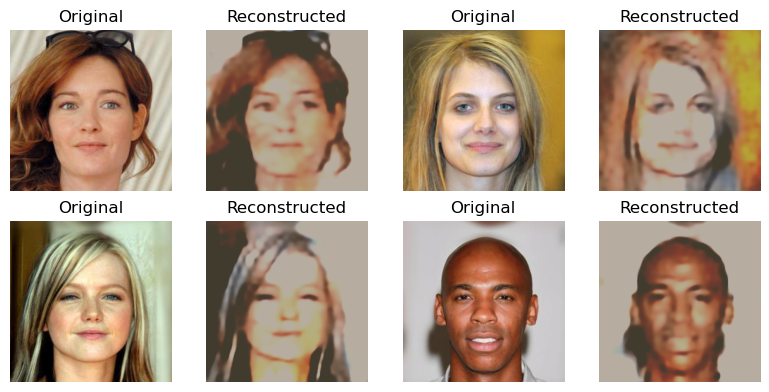

In [16]:
# 获取并展示重建的图像
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

model.eval()
with torch.no_grad():
    sample_data, _ = next(iter(dataloader))
    sample_data = sample_data.to(device)
    original_images = sample_data
    original_images = denormalize(original_images, mean=mean, std=std)
    reconstructed_images = model(sample_data)[0]
    reconstructed_images = denormalize(reconstructed_images, mean=mean, std=std)
    plot_images(original_images, reconstructed_images)